# Project Milestone 3

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

## Project Milestone 2- Data Preparation

In [4]:
# load dataset
factcheck = pd.read_json("politifact_factcheck_data.json", lines=True)
factcheck

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...
...,...,...,...,...,...,...,...,...
21147,mostly-false,Donald Trump,Says the large trade deficit with Japan stems ...,8/13/2019,speech,Jon Greenberg,8/15/2019,https://www.politifact.com/factchecks/2019/aug...
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",11/1/2019,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...
21149,mostly-false,Chris Abele,"""I have fought for our shared values without b...",1/4/2011,news,Dave Umhoefer,1/13/2011,https://www.politifact.com/factchecks/2011/jan...
21150,false,Bloggers,"""Germany halts all Covid-19 vaccines, says the...",8/27/2021,blog,Ciara O'Rourke,9/9/2021,https://www.politifact.com/factchecks/2021/sep...


In [5]:
# remove uneeded features
factcheck2 = factcheck.drop(["statement_originator", "factchecker", 
                             "factcheck_date", "factcheck_analysis_link",
                             "statement_date"], axis=1)
factcheck2

,verdict,statement,statement_source
0,true,John McCain opposed bankruptcy protections for...,speech
1,false,"""Bennie Thompson actively cheer-led riots in t...",television
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",news
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",blog
4,half-true,"""I'm the only (Republican) candidate that has ...",television
...,...,...,...
21147,mostly-false,Says the large trade deficit with Japan stems ...,speech
21148,false,"""Tens of thousands"" of people leave New York e...",social_media
21149,mostly-false,"""I have fought for our shared values without b...",news
21150,false,"""Germany halts all Covid-19 vaccines, says the...",blog


In [6]:
# encoding verdicts according to true/false
factcheck2["verdict_code"] = [0  if verdict == "mostly false" or verdict == "false"
                              or verdict == "pants-fire" else 1 for verdict in factcheck2.verdict]
factcheck2

,verdict,statement,statement_source,verdict_code
0,true,John McCain opposed bankruptcy protections for...,speech,1
1,false,"""Bennie Thompson actively cheer-led riots in t...",television,0
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",news,1
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",blog,0
4,half-true,"""I'm the only (Republican) candidate that has ...",television,1
...,...,...,...,...
21147,mostly-false,Says the large trade deficit with Japan stems ...,speech,1
21148,false,"""Tens of thousands"" of people leave New York e...",social_media,0
21149,mostly-false,"""I have fought for our shared values without b...",news,1
21150,false,"""Germany halts all Covid-19 vaccines, says the...",blog,0


In [7]:
# create dummies
dummies = pd.get_dummies(factcheck2.statement_source)
dummies

,advertisement,blog,campaign,email,meeting,news,other,radio,social_media,speech,statement,television,testimony
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,0,0,0,0,0,0,0,0,0,1,0,0,0
21148,0,0,0,0,0,0,0,0,1,0,0,0,0
21149,0,0,0,0,0,1,0,0,0,0,0,0,0
21150,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# rename statement columnd
dummies = dummies.rename(columns={"statement":"statement_s"})
dummies

,advertisement,blog,campaign,email,meeting,news,other,radio,social_media,speech,statement_s,television,testimony
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,0,0,0,0,0,0,0,0,0,1,0,0,0
21148,0,0,0,0,0,0,0,0,1,0,0,0,0
21149,0,0,0,0,0,1,0,0,0,0,0,0,0
21150,0,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# drop og column to data frame
factcheck3 = factcheck2.drop("statement_source", axis=1)

In [10]:
# add dummies to data frame
factcheck3 = pd.concat([factcheck3, dummies], axis=1)
factcheck3

,verdict,statement,verdict_code,advertisement,blog,campaign,email,meeting,news,other,radio,social_media,speech,statement_s,television,testimony
0,true,John McCain opposed bankruptcy protections for...,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,false,"""Bennie Thompson actively cheer-led riots in t...",0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,half-true,"""I'm the only (Republican) candidate that has ...",1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,mostly-false,Says the large trade deficit with Japan stems ...,1,0,0,0,0,0,0,0,0,0,1,0,0,0
21148,false,"""Tens of thousands"" of people leave New York e...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
21149,mostly-false,"""I have fought for our shared values without b...",1,0,0,0,0,0,1,0,0,0,0,0,0,0
21150,false,"""Germany halts all Covid-19 vaccines, says the...",0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
def clean_statements(statements):
    """prepares series of text data for sentiment analysis by:
       converting to lowercase, removing punctuation & special characters, 
       removing stop words, and stemming words. Joins tokenized words together 
       at the end for use with Vectorizers"""
    # convert all text to lowercase
    lowercase = statements.str.lower()
    # remove punctuation and special characters
    clean = [re.sub('[^A-Za-z0-9 ]+', '', statement) for statement in lowercase]
    # english stop words
    stop_words = stopwords.words("english")
    # tokenize review into words
    token_clean = [word_tokenize(review) for review in clean]
    # remove stop words
    cleaner = [[word for word in review if word not in stop_words ] for review in token_clean]
    # stem words
    porter = PorterStemmer()
    stemmed = [[porter.stem(word) for word in review] for review in cleaner]
    # join words back together
    cleaned = [" ".join(review) for review in stemmed]
    return cleaned

In [12]:
# create cleaned reviews for use with bag of words & tfidf
cleaned = clean_statements(factcheck3.statement)

In [13]:
# view cleaned statements
cleaned

['john mccain oppos bankruptci protect famili bankruptci medic expens couldnt pay',
 'benni thompson activ cheerl riot 90',
 'saysmaggi hassan state 30 day last three month',
 'bust cdc inflat covid number accus violat feder law',
 'im republicancandid actual reduc size govern',
 'actual 30 countri practic birthright citizenship',
 'husband never gotten penni money farm',
 'go strictli number crime across board last year 10 percent decreas seriou crime',
 'american peopl say dont touch social secur dont touch medicar dont cut defens that 84 percent feder budget',
 'sinc 1978 ceo compens rose 1000 119 averag worker',
 'say accomplish includ fiscal respons budget agreement control state spend',
 'say presid obama deal allow iran produc nuclear weapon',
 'say donald trump say climat chang hoax invent chines',
 'least 450000 ballot key state miracul mark joe biden candid',
 '70 percent american adult commit crime could lead imprison',
 'say stimulu bill sent tax credit oversea 12 billion s

In [14]:
# add cleaned into og dataframe
factcheck3["statement_processed"] = cleaned
factcheck3

,verdict,statement,verdict_code,advertisement,blog,campaign,email,meeting,news,other,radio,social_media,speech,statement_s,television,testimony,statement_processed
0,true,John McCain opposed bankruptcy protections for...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,john mccain oppos bankruptci protect famili ba...
1,false,"""Bennie Thompson actively cheer-led riots in t...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,benni thompson activ cheerl riot 90
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",1,0,0,0,0,0,1,0,0,0,0,0,0,0,saysmaggi hassan state 30 day last three month
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,bust cdc inflat covid number accus violat fede...
4,half-true,"""I'm the only (Republican) candidate that has ...",1,0,0,0,0,0,0,0,0,0,0,0,1,0,im republicancandid actual reduc size govern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,mostly-false,Says the large trade deficit with Japan stems ...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,say larg trade deficit japan stem send million...
21148,false,"""Tens of thousands"" of people leave New York e...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,ten thousand peopl leav new york everi week
21149,mostly-false,"""I have fought for our shared values without b...",1,0,0,0,0,0,1,0,0,0,0,0,0,0,fought share valu without ideologu partisan
21150,false,"""Germany halts all Covid-19 vaccines, says the...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,germani halt covid19 vaccin say unsaf longer r...


## Building Model- Random Forest Classifier

##### Step 1: Split Data

First we split the data into targets and features. We're looking at the processed statements to try and predict the target which is the veracity (coded as 0 or 1)

In [15]:
# set features and target
features = factcheck3["statement_processed"]
target = factcheck3["verdict_code"]

In [16]:
# split data
feat_train, feat_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, random_state=1)

##### Step 2: Create Term Frequency-Inverse Document Frequency Features

Next, we create a TF-IDF out of our features. I am using this so our model can use the weighted importance of the words in all the statements in order to make its predictions

In [17]:
# create tf-idf
tfidf = TfidfVectorizer()
# fit and transform train set
feature_matrix_train = tfidf.fit_transform(feat_train)
# transform but don't fit test set
feature_matrix_test = tfidf.transform(feat_test)

##### Step 3: Create Random Forest Classifier and Fit to Feature Matrix

For this first model, I am using a random forest classifier. I was between using a Logistic Regression Model and a Random Forest Model and decided on the latter because we have a fairly large data set, and at this point in the project I am not trying to extract why a decision was made, but trying to see if a model can predict veracity at all in the first place. As such, I thought using a Random Forest Classifier would give us a good indication at how well models in general would do, so that if it turns out that this initial model does not work well, we can investigate if we need to change some of our earlier data preparation work.

In [19]:
# random forest classifier
randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)
model_forest = randomforest.fit(feature_matrix_train, target_train)

##### Step 4: Make Predictions Using Forest Classifier

Now that the model has been fit, we will use it to predict values on the test set.

In [20]:
# make predictions
predictions_forest = model_forest.predict(feature_matrix_test)

##### Step 5: Evaluate Model

To evaluate the model, I'll be using precision, a confusion matrix, and an ROC Curve. I chose these metrics because the most important part of our model is in trying to find what features share in common that may influence why the are marked true or false. So I am using the metrics that will easily show how well the model guessed correctly when compared to chance.

In [25]:
# confusion matrix forest
conf_mat_forest = confusion_matrix(target_test, predictions_forest)
conf_mat_forest

array([[ 730,  972],
       [ 276, 2253]], dtype=int64)

In [32]:
# precision score
precision_forest = precision_score(target_test, predictions_forest)
print(f"Precision Score: {precision_forest}")

Precision Score: 0.6986046511627907


In [33]:
# predicted probabilities
target_prob_forest = model_forest.predict_proba(feature_matrix_test)[:, 1]
# true/false pos rates
fp_rate_forest, tp_rate_forest, treshold_forest = roc_curve(target_test, target_prob_forest)

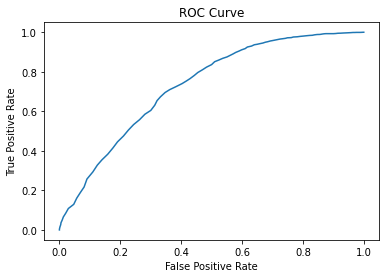

In [30]:
# plotting ROC curve
plt.title("ROC Curve")
plt.plot(fp_rate_forest, tp_rate_forest)
plt.ylabel("True Positive Rate"), plt.xlabel("False Positive Rate")
plt.show()

### Analysis of First Model

We can see based on the metrics we used to judge our model that it was better than chance at predicting whether a statement was true or false. However, There were nearly 1000 (almost a quarter of the training set) false positives, indicating a pretty wide error margin. The ROC curve is a visual representation of this matrix, suggesting that the model is better than chance but still has many false negatives and false positives. The precision score is only .69, which shows that our True Positive rate is not very high. 

For future steps, we should tune this model to see if other hyperparameters may be able to improve these scores. We should also look at other predictors, such as Naive Bayes and Logistic Regression to see if these methods perform better than this Random Forest.

Overall, however, the fact that our model has any predicitive power is encouraging. It suggests that there is something within the statements that can be used to detect if a statement is true or false. And while it is far to early to say what these things are, or what that even truly means, it does reveal that there is something to be learned through further analysis.